In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 均值为1，标准差为1
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\nlabels:', labels[0])

features: tensor([-0.6260, -1.5729]) 
labels: tensor([8.2956])


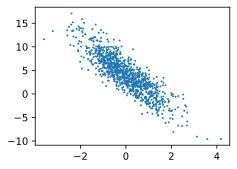

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 得到一个随机顺序，然后按这个顺序取出，得到随机取出的效果
    for i in range(0, num_examples, batch_size): # 从0开始，到num_examples - 1为止，步长为batch_size
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices] # yield不会立即返回

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6880, -0.3479],
        [ 1.0066,  1.2217],
        [ 0.4324, -1.2991],
        [-0.1217,  1.5604],
        [ 1.6267, -1.3457],
        [-1.4481,  1.3394],
        [ 0.8386,  0.1982],
        [ 1.1044, -2.1684],
        [-0.1196,  0.8331],
        [ 0.8636,  1.3469]]) 
 tensor([[ 4.0034],
        [ 2.0714],
        [ 9.4983],
        [-1.3506],
        [12.0259],
        [-3.2358],
        [ 5.2271],
        [13.7814],
        [ 1.1067],
        [ 1.3650]])


In [6]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [7]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

In [8]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [9]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad(): # 更新时不需要计算梯度
        for param in params: # 对于每个参数
            param -= lr * param.grad / batch_size # 将梯度取平均
            param.grad.zero_() # 清零梯度

In [10]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): # 取X，y的一个小批量
        l = loss(net(X, w, b), y) # 对这一个小批量求loss
        # 这里X - (batch_size, 2)
        # w - (2, 1)
        # 计算出的形状为(batch_size, 1)，是一个向量
        # 所以要先累加，也就是sum()，然后再反向传播求梯度
        l.sum().backward() # 反向传播求梯度
        sgd([w, b], lr, batch_size) # 随机梯度下降更新参数
    with torch.no_grad(): # 打印训练损失，不需要记录梯度
        train_l = loss(net(features, w, b), labels) # 对整个数据集计算损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}') # 打印损失

epoch 1, loss 0.032283
epoch 2, loss 0.000119
epoch 3, loss 0.000051


In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
